In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import wandb

wandb.login()
api = wandb.Api()

wandb: Currently logged in as: gooogleon (gooogleon-uni-hd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
RUN_NAMES = [
    "Incr",
    "Incr_Gen_Base",
    "Incr_Gen_MRTE",
    "Incr_Gen_Cap",
    "Incr_Gen_Cap_Large",
    "Incr_Gen_Cap_Large_RR",
    "Incr_Gen_Base_RR",
    "Incr_Gen_MRTE_RR",
    "Incr_Gen_Base_Large_RR",
    "Incr_Gen_MRTE_Large_RR",
    "Incr_Gen_Better_Cap_RR",
    "Incr_Gen_Better_Cap_Large_RR",
    "Incr_Gen_Lora_RR",
    "Incr_Gen_Lora_Large_RR",
]

In [4]:
os.chdir("/home/thesis/marx/wilson_gen/WILSON")

In [5]:
# # CLEAN UP ALL RUNS NOT LISTED IN WANDB HOMEPAGE

# run_ids = []
# for run in api.runs("WILSON"):
#     run_ids.append(run.id)

# for run in os.listdir("wandb"):
#     if "run-" in run:
#         if run.split("-")[-1] not in run_ids:
#             os.system(f"rm -rf wandb/{run}")

In [6]:
classes = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining_table",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv_monitor",
]

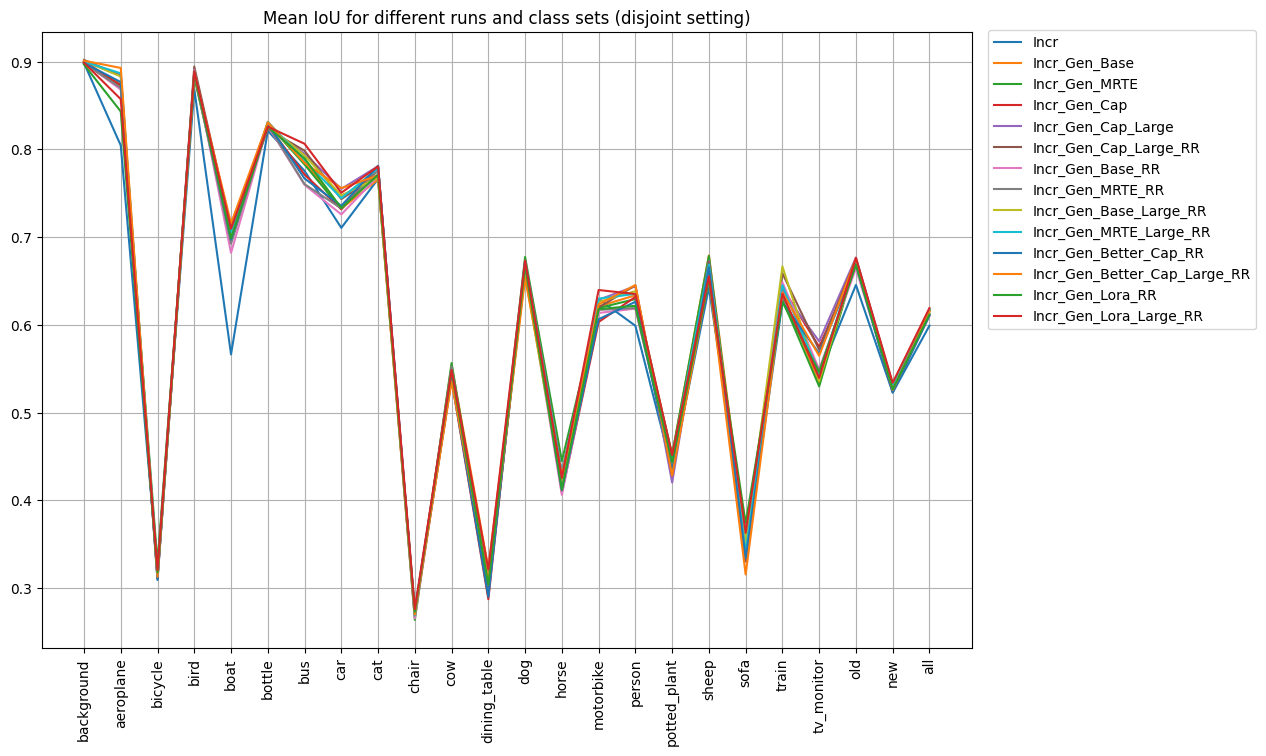

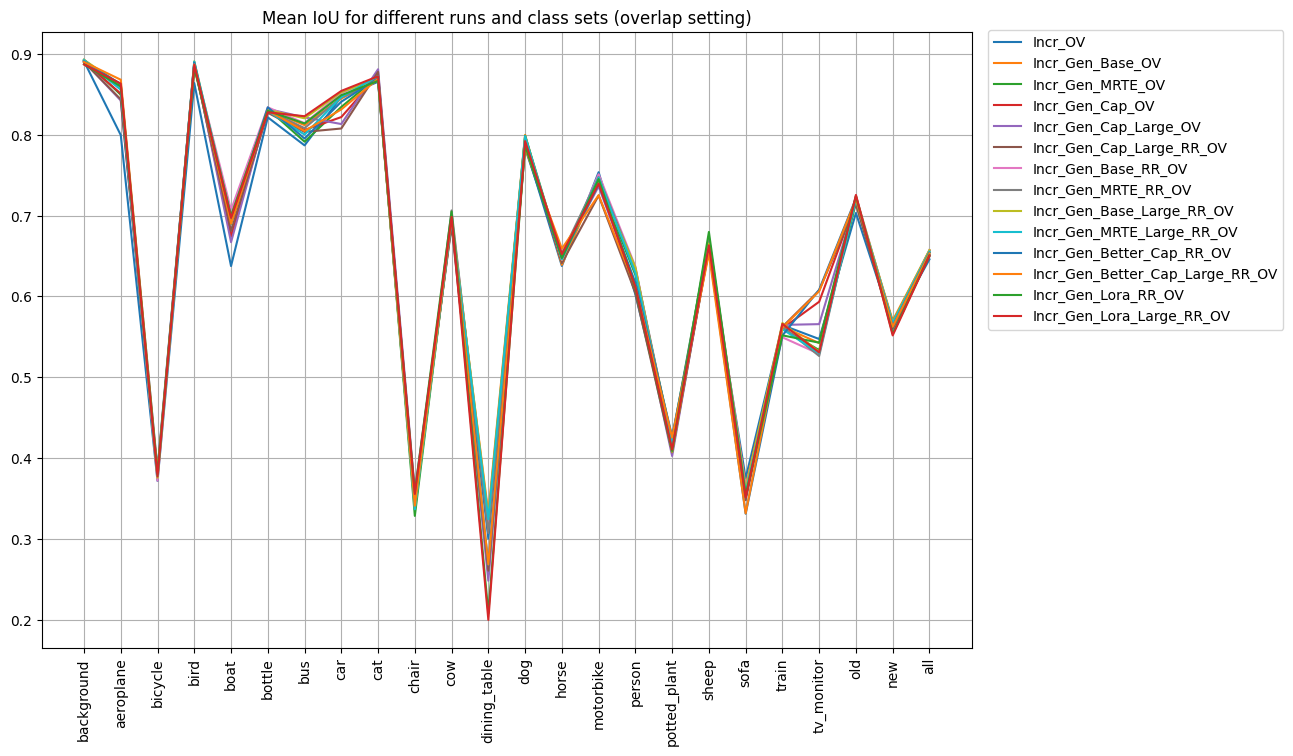

In [8]:
PLOT_MODE = "all"  # "all" or "means"
iou_dict = {True: {}, False: {}}
for OVERLAP in [False, True]:
    plt.figure(figsize=(12, 8))
    for name in RUN_NAMES:
        if OVERLAP:
            name += "_OV"
        found_flag = False
        for run in os.listdir("wandb"):
            if "run-" in run:
                with open(f"wandb/{run}/files/wandb-metadata.json", "r") as f:
                    metadata = json.load(f)
                run_name = metadata["args"][metadata["args"].index("--name") + 1]
                if "--overlap" in metadata["args"]:
                    run_name += "_OV"
                # print(name, run.split("-")[-1])
                if run_name == name:
                    found_flag = True
                    break
        if not found_flag:
            print(f"Could not find run for {name}")
            continue
        # see amount of training data for each run
        # with open(f"wandb/{run}/files/output.log", "r") as f:
        #     log = f.readlines()[1]
        # print(run)
        try:
            class_iou_name = os.listdir(f"wandb/{run}/files/media/table/Test/Class_IoU/1/")[0]
            with open(f"wandb/{run}/files/media/table/Test/Class_IoU/1/{class_iou_name}", "r") as f:
                table = json.load(f)
            data = np.array(table["data"][0])
            with open(f"wandb/{run}/files/wandb-summary.json", "r") as f:
                summary = json.load(f)
            mean_iou = np.array(summary["Val/MeanIoU/1"])
            run_iou_dict = {}
            for i, cl in enumerate(classes):
                if i > 0:
                    run_iou_dict[cl] = data[i]
            run_iou_dict["mean"] = mean_iou
            run_iou_dict["old"] = np.mean(data[1:11])
            run_iou_dict["new"] = np.mean(data[11:])
            if name == "Incr" + ("_OV" if OVERLAP else ""):
                base_mean = mean_iou
                base_old = np.mean(data[1:11])
                base_new = np.mean(data[11:])
            iou_dict[OVERLAP][name.replace("_OV", "")] = run_iou_dict
            if PLOT_MODE == "means":
                # plt.plot([0.5, 1.5, 2.5], [np.mean(data[1:11]) - base_old, np.mean(data[11:]) - base_new, mean_iou - base_mean], label=name)
                plt.plot([0.5, 1.5, 2.5], [np.mean(data[1:11]), np.mean(data[11:]), mean_iou], label=name)
                # plt.plot([0, 1], [np.mean(data[1:11]) - base_old] * 2, label=name)
                # plt.plot([1, 2], [np.mean(data[11:]) - base_new] * 2)
                # plt.plot([2, 3], [mean_iou - base_mean] * 2)
            elif PLOT_MODE == "all":
                plt.plot(data.tolist() + [np.mean(data[1:11]), np.mean(data[11:]), mean_iou], label=name)
        except FileNotFoundError as e:
            # print(e)
            print(f"Could not find data for {name}")
            continue
    plt.legend(bbox_to_anchor=(1.01, 1.014))
    if PLOT_MODE == "means":
        plt.xticks([0.5, 1.5, 2.5], ["old", "new", "all"])
    if PLOT_MODE == "all":
        plt.xticks(np.arange(24), classes + ["old", "new", "all"], rotation=90)
        plt.grid()
    plt.title(f"Mean IoU for different runs and class sets ({'overlap' if OVERLAP else 'disjoint'} setting)")
    plt.show()

In [7]:
for cl in classes[1:] + ["old", "new", "mean"]:
    best = 0.0
    best_name = ""
    for name in RUN_NAMES:
        if iou_dict[False][name][cl] > best:
            best = iou_dict[False][name][cl]
            best_name = name
    for name in RUN_NAMES:
        if name == best_name:
            iou_dict[False][name][cl] = f"\\textbf{{{str(np.round(100 * iou_dict[False][name][cl], 2))}}}"
        else:
            iou_dict[False][name][cl] = f"{str(np.round(100 * iou_dict[False][name][cl], 2))}"
for cl in classes[1:] + ["old", "new", "mean"]:
    best = 0.0
    best_name = ""
    for name in RUN_NAMES:
        if name in iou_dict[True]:
            if iou_dict[True][name][cl] > best:
                best = iou_dict[True][name][cl]
                best_name = name
    for name in RUN_NAMES:
        if name in iou_dict[True]:
            if name == best_name:
                iou_dict[True][name][cl] = f"\\textbf{{{str(np.round(100 * iou_dict[True][name][cl], 2))}}}"
            else:
                iou_dict[True][name][cl] = f"{str(np.round(100 * iou_dict[True][name][cl], 2))}"

In [8]:
def get_line(name, overlap):
    line = f"            {name.replace("_", "-")} & "
    for cl in classes[1:]:
        try:
            line += f"{iou_dict[overlap][name][cl]} & "
        except KeyError:
            line += "- & "
    try:
        line += f"{iou_dict[overlap][name]['old']} & "
    except KeyError:
            line += "- & "
    try:
        line += f"{iou_dict[overlap][name]['new']} & "
    except KeyError:
            line += "- & "
    try:
        line += f"{iou_dict[overlap][name]['mean']} \\\\"
    except KeyError:
            line += f"- \\\\"
    return line

In [9]:
# print above table structure
print("    \\begin{table}[H]")
print("    \\centering")
print("    \\resizebox{\\columnwidth}{!}{%")
print("        \\begin{tabular}{|c|cccccccccc|cccccccccc|cc|c|}")
print("            \\hline")
print("            model & aplane & cycle & bird & boat & bottle & bus & car & cat & chair & cow & dtable & dog & horse & mbike & person & pplant & sheep & sofa & train & tv & old & new & all \\\\")
print("            \\hline")
for name in RUN_NAMES:
    print(get_line(name, overlap=False))
print("            \\hline")
print("        \\end{tabular}%")
print("    }")
print("    \\caption{Results for the VOC 10-10 disjoint setting.}")
print("    \\label{tab:results_dj}")
print("    \\end{table}")
print("")
print("")
print("")
print("    \\begin{table}[H]")
print("    \\centering")
print("    \\resizebox{\\columnwidth}{!}{%")
print("        \\begin{tabular}{|c|cccccccccc|cccccccccc|cc|c|}")
print("            \\hline")
print("            model & aplane & cycle & bird & boat & bottle & bus & car & cat & chair & cow & dtable & dog & horse & mbike & person & pplant & sheep & sofa & train & tv & old & new & all \\\\")
print("            \\hline")
for name in RUN_NAMES:
    print(get_line(name, overlap=True))
print("            \\hline")
print("        \\end{tabular}%")
print("    }")
print("    \\caption{Results for the VOC 10-10 overlap setting.}")
print("    \\label{tab:results_ov}")
print("    \\end{table}")

    \begin{table}[H]
    \centering
    \resizebox{\columnwidth}{!}{%
        \begin{tabular}{|c|cccccccccc|cccccccccc|cc|c|}
            \hline
            model & aplane & cycle & bird & boat & bottle & bus & car & cat & chair & cow & dtable & dog & horse & mbike & person & pplant & sheep & sofa & train & tv & old & new & all \\
            \hline
            Incr & 80.46 & 32.18 & 86.89 & 56.64 & 82.13 & 77.56 & 71.06 & 76.63 & 27.43 & 54.56 & 29.63 & 66.15 & 41.42 & 62.95 & 59.9 & 43.49 & 64.26 & 36.06 & 64.59 & 54.28 & 64.55 & 52.27 & 59.91 \\
            Incr-Gen-Base & 87.47 & 31.84 & 88.24 & 70.29 & \textbf{83.16} & 78.61 & 73.26 & 76.58 & 26.66 & 55.38 & \textbf{32.24} & 66.2 & 42.69 & 62.11 & 63.37 & 45.16 & \textbf{67.92} & 35.4 & 63.6 & 53.44 & 67.15 & 53.21 & 61.59 \\
            Incr-Gen-MRTE & 87.3 & \textbf{32.81} & 88.3 & 69.77 & 82.95 & 78.29 & 73.19 & 78.01 & 26.36 & \textbf{55.64} & 30.62 & \textbf{67.74} & \textbf{44.48} & 61.93 & 62.94 & \textbf{45.21} & 67.86 & 3